## Exploratory Data Analysis

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

amd_df = pd.read_csv("./data/AMD.csv",parse_dates=["Date"],index_col="Date")
print(amd_df.info())
print(amd_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8843 entries, 1983-03-21 to 2018-04-16
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Adj_Close   8843 non-null   float64
 1   Adj_Volume  8843 non-null   float64
dtypes: float64(2)
memory usage: 207.3 KB
None
            Adj_Close  Adj_Volume
Date                             
1983-03-21   8.997535    510800.0
1983-03-22   8.497672    328000.0
1983-03-23   8.717612    427200.0
1983-03-24   8.780094    393200.0
1983-03-25   8.872569    210400.0


<AxesSubplot:xlabel='Date'>

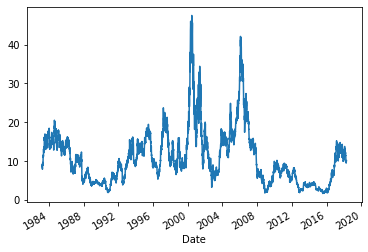

In [24]:
# Adj_Close shows (adjusted) closing stock prices 
amd_df["Adj_Close"].plot()

<AxesSubplot:ylabel='Frequency'>

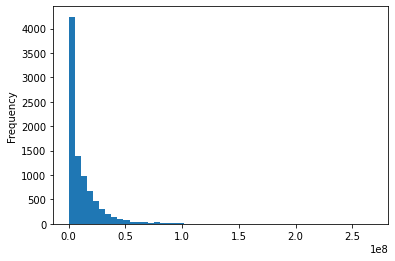

In [25]:
vol = amd_df["Adj_Volume"]
vol.plot.hist(bins=50)

We can use machine learning in many ways - we can predict the raw prices of stocks, but typically we predict percentage changes. This makes it easier to interpret the results as well as make gneeral purpose models for the data.

To get the percentage changes use the `.pct_change()` methods:

<AxesSubplot:ylabel='Frequency'>

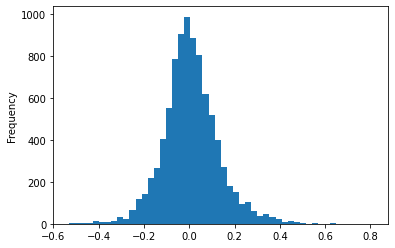

In [26]:
amd_df['10d_close_pct'] = amd_df["Adj_Close"].pct_change(10)
amd_df['10d_close_pct'].plot.hist(bins = 50)

Typically, for stocks, percentage changes are right-skewed normally distributed. **This gives "some" motivation for using something like a linear model** - the right skew is a problem (potentally needs transformation i.e. via log or square-root transformation)

Another tool is the `.shift()` - shifts the index by given amount. creates a new column with the closing price from 10days in future. We can get the price percentage change 10 days in the future:

In [27]:
amd_df['10d_future_close'] = amd_df["Adj_Close"].shift(-10)
amd_df['10d_future_close_pct'] = amd_df["10d_future_close"]

We can also look at any correlations: using the `.corr` method - however this is not very accurate/reliable. Another option is to look at the scatter plot.

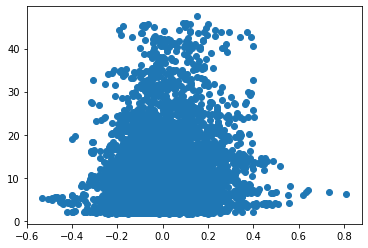

In [34]:
plt.scatter(amd_df['10d_close_pct'], amd_df["10d_future_close_pct"])
plt.show()

## Identifying features and targets

To apply machine learning methods - we need featuers and targets. In this setting, features are the inputs we need to predict future price changes - in this case this is the 10-day price change and volume. The targets are the future price changes -- since this is what we want to predict.

Other usefull features to incorporate are historical data - e.g. the moving average. The moving average is useful as it allows us to concentrate past data into a single point.

Another indicated that is useful is the relative strength index, or RSI. RSI clos to - means price is due to rebound from recent lows, RSI close to 100 may mean prices of the stock is due to decline.

The eq for RSI is :

$$ 100-\frac{100}{1+\text{RS}}$$

here, RS - relative strength is given by 

$$\text{RS} = \frac{\text{Average gain over n periods}}{\text{Average loss over n periods}}$$

is the average gain of price increases divided by the average loss of price decreases during the time prediod, $n$.

In [53]:
import talib


# Must provide numpy arrays not pandas series / df
amd_df['ma200']= talib.SMA(amd_df['Adj_Close'].values, timeperiod = 200)
amd_df['rsi200'] = talib.RSI(amd_df['Adj_Close'].values, timeperiod = 200)

#Drop all na values
amd_df = amd_df.dropna()

# Features:

feature_names = ['10d_close_pct', 'ma200', 'rsi200']
features = amd_df[feature_names]
targets = amd_df['10d_future_close_pct']

feature_target_df = amd_df[feature_names + ['10d_future_close_pct']]

## Linear modelling

 We want to split data into train and test sets - but can't use sklearns `train_test_split` as it randomly shuffles the train test data. In this context, we want to use earler (in terms of date) as the training data and the more recent prices as the test set.

In [54]:
# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm


# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(8433, 4) (7168, 4) (1265, 4)


In [57]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                             
Dep. Variable:     10d_future_close_pct   R-squared:                       0.839
Model:                              OLS   Adj. R-squared:                  0.839
Method:                   Least Squares   F-statistic:                 1.244e+04
Date:                  Wed, 29 Jun 2022   Prob (F-statistic):               0.00
Time:                          12:41:09   Log-Likelihood:                -17921.
No. Observations:                  7168   AIC:                         3.585e+04
Df Residuals:                      7164   BIC:                         3.588e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -50.9779  

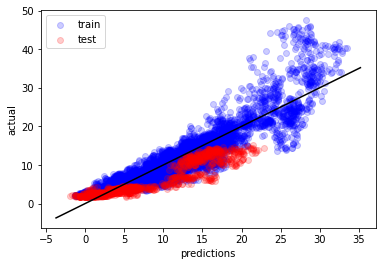

In [61]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

## Enginering Features

Something else to conisder here is the effects feature interactions. Feature interactions occurs when effects of features are combined. E.g. multipling the 14-day moving average and RSI togeter, the resulting correlation may be stronger than the individual features - The linear model above is a little limited as we must explicitly add feature interactions, whereas other models may be able to learn non-linear releationships between the features and targets. For example these include random forests, gradient boosting and NN.

More complex models allow us to engineer more features (why?) - this may improve predictive performance. The volume data will be added as a new feature. Although the volume is essentially uncorrelated to movements price, the combinations of volume and other features may add some predictive power. 

In [66]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
amd_df["Adj_Volume_1d_change"] = amd_df['Adj_Volume'].pct_change()
amd_df["Adj_Volume_1d_change_SMA"] = talib.SMA(amd_df["Adj_Volume_1d_change"].values,
                        timeperiod=5)

<Figure size 432x288 with 0 Axes>

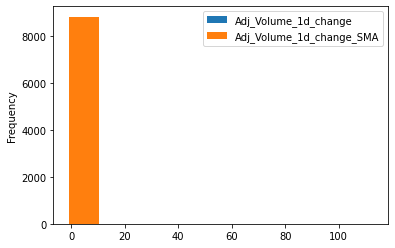

In [71]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']

# Plot histogram of volume % change data
plt.clf()
amd_df[new_features].plot(kind='hist', sharex=False, bins=10)
plt.show()

In [73]:
amd_df["Adj_Volume_1d_change"]

Date
1983-03-21         NaN
1983-03-22   -0.357870
1983-03-23    0.302439
1983-03-24   -0.079588
1983-03-25   -0.464903
                ...   
2018-04-10    0.121250
2018-04-11   -0.322219
2018-04-12    0.638174
2018-04-13   -0.185181
2018-04-16   -0.258390
Name: Adj_Volume_1d_change, Length: 8843, dtype: float64